In [1]:
import pandas as pd
import numpy as np

In [2]:
# dataset 

df = pd.read_csv("HPC2N-2002-2.2-cln.csv")
df.head()

,JobID,SubmitTime,WaitTime,RunTime,AllocatedProcessors,AvgCPUTimeUsed,UsedMemory,RequestedProcessors,RequestedTime,RequestedMemory,Status,UserID,GroupID,ExecutableID,QueueID,PartitionID,PrecedingJobID,ThinkTimeFromPrecedingJob
0,11,342072,32,43306,32,43307.00,-1,32,43200,-1,1,4,1,-1,-1,1,-1,-1
1,12,342343,5,553,40,552.21,-1,40,43200,-1,1,4,1,-1,-1,1,-1,-1
2,13,342921,102,10027,40,10027.00,-1,40,43200,-1,1,4,1,-1,-1,1,-1,-1
3,14,347226,15,33156,8,33157.00,-1,8,86400,-1,1,5,1,-1,-1,1,-1,-1
4,15,347593,15,86462,8,86464.00,-1,8,86400,-1,1,5,1,-1,-1,1,-1,-1


# About Data

# Standard Workload Format (SWF)
The standard workload format (swf) was defined in order to ease the use of workload logs and models. With it, programs that analyze workloads or simulate system scheduling need only be able to parse a single format, and can be applied to multiple workloads.

The standard workload format abides by the following principles:

The files are portable and easy to parse:
* Each workload is stored in a single ASCII file.
* Each job (or roll) is represented by a single line in the file.
* Lines contain a predefined number of fields, which are mostly integers, separated by whitespace. Fields that are irrelevant for a specific log or model appear with a value of -1.
* Comments are allowed, as identified by lines that start with a `;'. In particular, files are expected to start with a set of header comments that define the environment or model. 
<br>
<br>

The same format is used for models and logs. This implies that in each context certain fields may be redundant; for example, logs do not contain data about feedback and depdencies among jobs, which might appear in models, whereas models do not contain data about wait times in queues.
The format is completely defined, with no scope for user extensability. Thus you are guaranteed to be able to parse any file that adheres to the standard, and multiple competing and incompatible extensions are avoided. If experience shows that important attributes have been left out, they will be included in the future by creating an updated version of the standard.

In [3]:
# columns in dataset
df.columns, len(df.columns)

(Index(['JobID', 'SubmitTime', 'WaitTime', 'RunTime', 'AllocatedProcessors',
        'AvgCPUTimeUsed', 'UsedMemory', 'RequestedProcessors', 'RequestedTime',
        'RequestedMemory', 'Status', 'UserID', 'GroupID', 'ExecutableID',
        'QueueID', 'PartitionID', 'PrecedingJobID',
        'ThinkTimeFromPrecedingJob'],
       dtype='object'),
 18)

In order to predict the resource usage of jobs in a HPC cluster, we will be using the Standard Workload Format (SWF) datasets available from the [Parallel Workloads Archive](http://www.cs.huji.ac.il/labs/parallel/workload/). The datasets contain information about job submissions, including job IDs, submission times, wait times, run times, number of allocated processors, average CPU time used, and memory usage. These datasets are widely used in research for evaluating scheduling algorithms and resource management techniques in HPC environments.

### We will be reimplementing the Research Paper given below:
<h4>"Improving HPC System Performance by Predicting Job Resources via Supervised Machine Learning"</h4>

## Features used in research paper model training:

| Feature            | Type    | Description                                                |
|--------------------|---------|------------------------------------------------------------|
| job_id             | Numeric | Id of submitted job                                        |
| username           | Text    | User name of submitted job                                 |
| submit             | Date    | Date and time of job submission                            |
| wclimit            | Numeric | Requested time in minutes (predicted variable)             |
| duration           | Numeric | Actual running wall time for the job in seconds            |
| cpu_per_task       | Numeric | Number of requested CPUs per task                          |
| req_mem            | Numeric | Requested memory for job at submission time in MB (predicted variable) |
| req_mem_per_cpu    | Numeric | Required memory per CPU                                    |


## similar columns in our dataset:

| Column | Description |
|---|--------------------------------------------------------|
| JobID | Unique identifier for each job |
| SubmitTime | Date and time of job submission |
| RequestedTime | Requested time in minutes (predicted variable) |
| RunTime | Actual running wall time for the job in seconds |
| AllocatedProcessors | Number of allocated processors |   
| RequestedProcessors | Number of requested processors |
| UsedMemory | Memory used by the job in MB |
| RequestedMemory | Requested memory in MB |

`Here the data is similar to the research paper except for few columns. We will be using the columns mentioned above to predict the requested_time and used_memory of the jobs submitted to the HPC cluster.`

In [4]:
dataset = df[["JobID", "SubmitTime", "RequestedTime", "RunTime", "AllocatedProcessors", "RequestedProcessors", "UsedMemory", "RequestedMemory"]]

In [5]:
dataset.head()

,JobID,SubmitTime,RequestedTime,RunTime,AllocatedProcessors,RequestedProcessors,UsedMemory,RequestedMemory
0,11,342072,43200,43306,32,32,-1,-1
1,12,342343,43200,553,40,40,-1,-1
2,13,342921,43200,10027,40,40,-1,-1
3,14,347226,86400,33156,8,8,-1,-1
4,15,347593,86400,86462,8,8,-1,-1


In [6]:
# missing columns
# req_mem_per_cpu

# dataset["requestedMemory_per_cpu"] = dataset["RequestedMemory"] / dataset["RequestedProcessors"]


In [7]:
dataset.head()

,JobID,SubmitTime,RequestedTime,RunTime,AllocatedProcessors,RequestedProcessors,UsedMemory,RequestedMemory
0,11,342072,43200,43306,32,32,-1,-1
1,12,342343,43200,553,40,40,-1,-1
2,13,342921,43200,10027,40,40,-1,-1
3,14,347226,86400,33156,8,8,-1,-1
4,15,347593,86400,86462,8,8,-1,-1


In [8]:
# shape of the dataset

dataset.shape

(202871, 8)

In [9]:
# checking the total number of -1 values in each row

for col in dataset.columns:
    print(f"{col}: {sum(dataset[col] == -1)}")

print(dataset.shape)
        

JobID: 0
SubmitTime: 0
RequestedTime: 0
RunTime: 0
AllocatedProcessors: 0
RequestedProcessors: 0
UsedMemory: 2138
RequestedMemory: 27512
(202871, 8)


In [10]:
#replacing -1 with nan values

dataset = dataset.replace(-1, np.nan)

In [11]:
# dropping the nan values

copyDataset = dataset.copy()
copyDataset.head()

,JobID,SubmitTime,RequestedTime,RunTime,AllocatedProcessors,RequestedProcessors,UsedMemory,RequestedMemory
0,11,342072,43200,43306,32,32,NaN,NaN
1,12,342343,43200,553,40,40,NaN,NaN
2,13,342921,43200,10027,40,40,NaN,NaN
3,14,347226,86400,33156,8,8,NaN,NaN
4,15,347593,86400,86462,8,8,NaN,NaN


In [12]:
copyDataset = dataset.dropna()

In [13]:
copyDataset.head()

,JobID,SubmitTime,RequestedTime,RunTime,AllocatedProcessors,RequestedProcessors,UsedMemory,RequestedMemory
3023,7019,4796419,43200,12322,16,16,57344.0,972800.0
3048,7047,4851035,43200,452,16,16,57344.0,972800.0
4110,26226,6745127,36000,6,16,16,409600.0,409600.0
4116,26253,6759830,90000,60107,8,8,409600.0,409600.0
4222,26537,6855164,60,1,120,120,921600.0,921600.0


In [14]:
copyDataset.shape

(175358, 8)

In [15]:
# missing columns
# req_mem_per_cpu

copyDataset["requestedMemory_per_cpu"] = copyDataset["RequestedMemory"] / copyDataset["RequestedProcessors"]

/tmp/ipykernel_385862/3796801717.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copyDataset["requestedMemory_per_cpu"] = copyDataset["RequestedMemory"] / copyDataset["RequestedProcessors"]


In [16]:
copyDataset.head()

,JobID,SubmitTime,RequestedTime,RunTime,AllocatedProcessors,RequestedProcessors,UsedMemory,RequestedMemory,requestedMemory_per_cpu
3023,7019,4796419,43200,12322,16,16,57344.0,972800.0,60800.0
3048,7047,4851035,43200,452,16,16,57344.0,972800.0,60800.0
4110,26226,6745127,36000,6,16,16,409600.0,409600.0,25600.0
4116,26253,6759830,90000,60107,8,8,409600.0,409600.0,51200.0
4222,26537,6855164,60,1,120,120,921600.0,921600.0,7680.0


## Here our dataset is ready with all the cleaned Data

### Further we will be doing EDA, Feature Engineering and Model Training

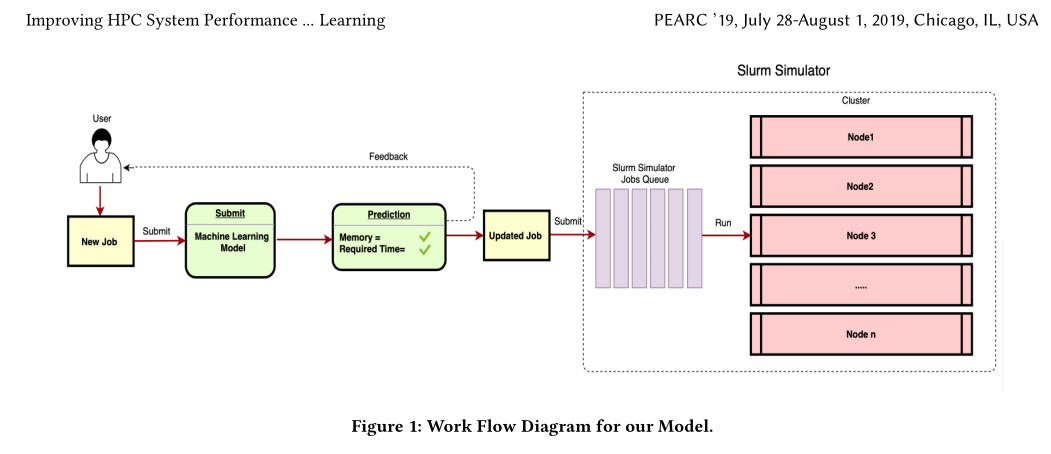

### Insights:
- Here the researchers are predicting both requested time and requested memory using supervised machine learning models.
- We will be following the same approach to predict the requested time and used memory of jobs submitted to the HPC cluster.
- We will be using various machine learning algorithms such as Linear Regression, Decision Trees, Random Forests, Gradient Boosting, etc. to build the predictive models.


In [17]:
# saving new dataset on file

copyDataset.to_csv("filtered_hpc_dataset.csv")